In [ ]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
alt.data_transformers.disable_max_rows()
alt.renderers.enable('default')
import plotly.express as px
import pycountry

In [5]:
df = pd.read_csv('agrofood_co2_emission_cleaned.csv')
df = df.convert_dtypes()

print("columns:\n\n", df.columns, "\n\n")
print("description:\n\n", df.describe())


columns:

 Index(['Area', 'Year', 'Savanna fires', 'Forest fires', 'Crop Residues',
       'Rice Cultivation', 'Drained organic soils (CO2)',
       'Pesticides Manufacturing', 'Food Transport', 'Forestland',
       'Net Forest conversion', 'Food Household Consumption', 'Food Retail',
       'On-farm Electricity Use', 'Food Packaging',
       'Agrifood Systems Waste Disposal', 'Food Processing',
       'Fertilizers Manufacturing', 'IPPU', 'Manure applied to Soils',
       'Manure left on Pasture', 'Manure Management', 'Fires in organic soils',
       'Fires in humid tropical forests', 'On-farm energy use',
       'Rural population', 'Urban population', 'Total Population - Male',
       'Total Population - Female', 'total_emission', 'Average Temperature °C',
       'Total Population', 'Temperature Category', 'Population Size'],
      dtype='object') 


description:

              Year  Savanna fires  Forest fires  Crop Residues  \
count      6965.0         6965.0        6965.0         6

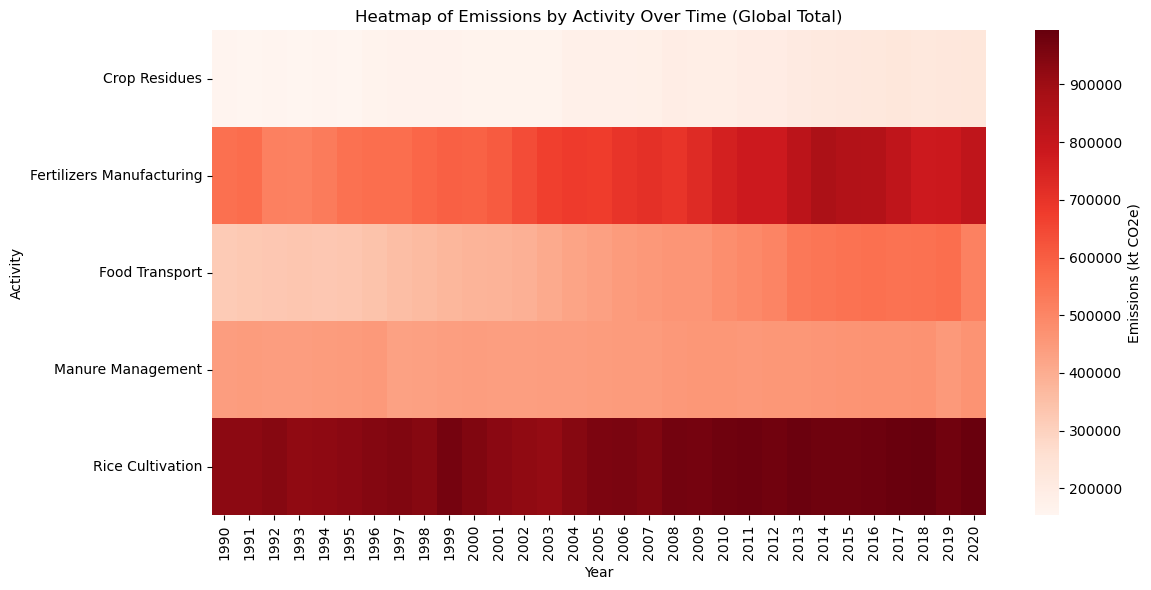

In [25]:
# Group by Activity and Year
emissions_df = df[['Year', 'Crop Residues', 'Food Transport', 'Manure Management', 'Fertilizers Manufacturing', 'Rice Cultivation']]
emissions_long = emissions_df.melt(
    id_vars='Year',       
    var_name='Activity',   
    value_name='Emissions' 
)
emissions_grouped = emissions_long.groupby(['Activity', 'Year'])['Emissions'].sum().reset_index()

heatmap_df = emissions_grouped.pivot(index='Activity', columns='Year', values='Emissions')

heatmap_df = heatmap_df.astype(float)

heatmap_df = heatmap_df[sorted(heatmap_df.columns)]

# Step 6: Plot
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_df, cmap='Reds', annot=False, cbar_kws={'label': 'Emissions (kt CO2e)'})
plt.title('Heatmap of Emissions by Activity Over Time (Global Total)')
plt.xlabel('Year')
plt.ylabel('Activity')
plt.tight_layout()
plt.show()


In [ ]:
natural_sources = [
    "Savanna fires", "Forest fires", "Crop Residues", "Rice Cultivation",
    "Drained organic soils (CO2)", "Manure applied to Soils", "Manure left on Pasture",
    "Fires in organic soils", "Fires in humid tropical forests"
]

manmade_sources = [
    "Pesticides Manufacturing", "Food Transport", "Food Household Consumption",
    "Food Retail", "On-farm Electricity Use", "Food Packaging",
    "Agrifood Systems Waste Disposal", "Food Processing", "Fertilizers Manufacturing",
    "IPPU", "Manure Management", "On-farm energy use"
]

df_natural = df[["Year"] + natural_sources].set_index("Year")
df_manmade = df[["Year"] + manmade_sources].set_index("Year")


# Sum emissions over all years for each column
total_natural = df[natural_sources].sum()
total_manmade = df[manmade_sources].sum()

# Get the top 5 emitters in each category
top5_natural = total_natural.sort_values(ascending=False).head(5).index.tolist()
top5_manmade = total_manmade.sort_values(ascending=False).head(5).index.tolist()

# Subset the original dataframe to just these top 5
df_natural_top5_grouped = df.groupby('Year')[top5_natural].sum()
df_manmade_top5_grouped = df.groupby('Year')[top5_manmade].sum()

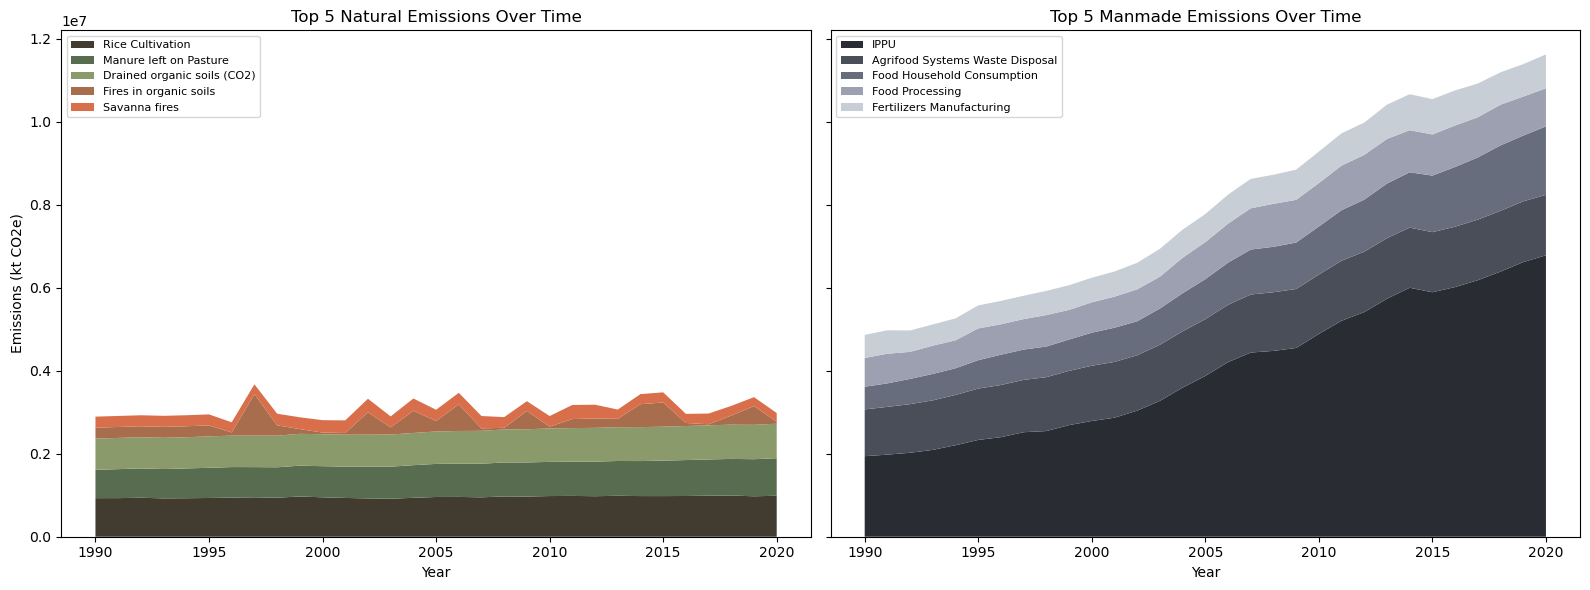

In [51]:
# Plot side-by-side stacked area charts
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Natural emissions - top 5
axes[0].stackplot(
    df_natural_top5_grouped.index,
    *[df_natural_top5_grouped[col] for col in top5_natural],
    labels=top5_natural,
    colors=['#d96e4a', '#a86d4d', '#8b9a6a', '#586d4f', '#413b30'][::-1]
)
axes[0].set_title("Top 5 Natural Emissions Over Time")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Emissions (kt CO2e)")
axes[0].legend(loc='upper left', fontsize=8)

# Manmade emissions - top 5
axes[1].stackplot(
    df_manmade_top5_grouped.index,
    *[df_manmade_top5_grouped[col] for col in top5_manmade],
    labels=top5_manmade,
    colors=['#292c33', '#4a4e59', '#686d7d', '#9ca0b0', '#c8ced5']
)
axes[1].set_title("Top 5 Manmade Emissions Over Time")
axes[1].set_xlabel("Year")
axes[1].legend(loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()